In [42]:
using Flux, Zygote, LinearAlgebra, Optim, Plots, Statistics

1. The given function from the problem statement is shown below. The gradient can be calculated using Flux's gradient calculation, and the Hessian with Zygote's.

In [77]:
# given function
f(x) = 100 * (x[2] - x[1] ^ 2) ^ 2 + (1 - x[1]) ^ 2

# initial x
x_0 = [-1.2, 1]

2-element Vector{Float64}:
 -1.2
  1.0

In [78]:
# part a
df(x) = Flux.gradient(f, x)
df(x_0)

([-215.59999999999997, -87.99999999999999],)

In [80]:
# part b

# we can just use Zygote's Hessian
d2f(x) = Zygote.hessian(f, x)
d2f(x_0)

2×2 Matrix{Float64}:
 1330.0  480.0
  480.0  200.0

In [46]:
# part c, i

# givens
alpha = 1
tol = 1e-5
max_iter = 1000000

# normal gradient descent function using Flux
function GD(f, df, x_0, alpha, max_iter, tol)
    
    # initial conditions for the loop; we also need to keep track of f_trace for plotting
    x = x_0
    iter = 0
    func_prev = f(x)
    f_trace = []
    
    # calculates gradient and moves in the direction of the negative gradient at each step multiplied by the step-size
    while iter < max_iter
        grad = df(x)[1]
        normalized_grad = grad / norm(grad)
        x = x - alpha * normalized_grad
        
        func = f(x)
        append!(f_trace, func)
        
        # if it meets the given tolerance, the function will exit the loop to return vars we want
        if norm(grad) <= tol
            return x, iter, f_trace
            
        end
        
        # alpha update
        if func > func_prev
            alpha *= 0.5
        
        end
        
        iter += 1
        func_prev = func
        
    end
    
    return x, iter, f_trace
    
end

# calls function with our givens
GD_res = GD(f, df, x_0, alpha, max_iter, tol)
println("After ", GD_res[2], " iterations, the value of f(x) = ", GD_res[1])

After 15149 iterations, the value of f(x) = [0.9999995461816826, 0.9999990879015064]


In [47]:
# part c, ii

# Newton's method function
function Newton(f, df, x_0, alpha, max_iter, tol)
    
    # initial conditions for the loop; we also need to keep track of f_trace for plotting
    x = x_0
    iter = 0
    func_prev = f(x)
    f_trace = []
    
    # since this is the multivariable case, we need to calculate the gradient and the hessian to and use the Newton's method equation to update our guess at each iteration
    while iter < max_iter
        grad = df(x)[1]
        hess = d2f(x)
        
        x = x - inv(hess) * grad
        
        func = f(x)
        append!(f_trace, func)
        
        # if it meets the given tolerance, the function will exit the loop to return vars we want
        if norm(grad) <= tol
            return x, iter, f_trace
            
        end
        
        # alpha update
        if func > func_prev
            alpha *= 0.5
        
        end
        
        iter += 1
        func_prev = func
        
    end
    
    return x, iter, f_trace
    
end

# calls function with our givens
Newton_res = Newton(f, df, x_0, alpha, max_iter, tol)
println("After ", Newton_res[2], " iterations, the value of f(x) = ", Newton_res[1])

After 5 iterations, the value of f(x) = [0.9999999999999999, 0.9999999999814724]


In [48]:
# part c, iii

# BFGS using Optim's BFGS
function BFGS(f, df, x_0, tol)
    
    # the result from the optimize function
    res = optimize(f, x_0, Optim.BFGS(), Optim.Options(g_tol = tol, store_trace = true))
        
    # we want to return these values
    min = Optim.minimizer(res)
    iter = res.iterations
    f_trace = Optim.f_trace(res)
    
    return min, iter, f_trace
    
end

# calls function with our givens
BFGS_res = BFGS(f, df, x_0, tol)
println("After ", BFGS_res[2], " iterations, the value of f(x) = ", BFGS_res[1])

After 28 iterations, the value of f(x) = [1.0000001002174672, 1.0000001863107844]


Using the three optimization models, we can see that Newton took the least about of iterations to complete, then BFGS, then standard GD. (BFGS is defaulted to $\alpha = 1$)

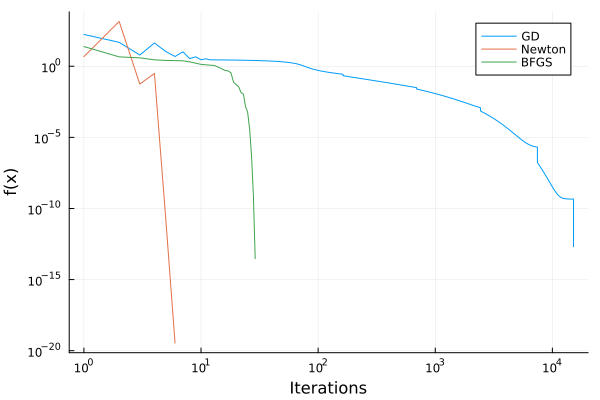

In [49]:
# part d

# retreives the trace arrays from their respective optimizers
f_trace_GD = GD_res[3]
f_trace_Newton = Newton_res[3]
f_trace_BFGS = BFGS_res[3]

# the size of the iterations for plotting
iter_GD = range(1, size(f_trace_GD)[1])
iter_Newton = range(1, size(f_trace_Newton)[1])
iter_BFGS = range(1, size(f_trace_BFGS)[1])

# plots
Plots.plot(iter_GD, f_trace_GD, xaxis=:log, yaxis=:log, label = "GD", xlabel = "Iterations", ylabel = "f(x)")
Plots.plot!(iter_Newton, f_trace_Newton, label = "Newton")
Plots.plot!(iter_BFGS, f_trace_BFGS, label = "BFGS")

In [50]:
# 2
using Random, DataFrames, CSV

# sets the seed
Random.seed!(24)

# givens
N_train = 50000
N_test = 2416
alpha = 1

# the given data set
data = CSV.read("Tetuan_City_power_consumption.csv", DataFrame)

# given list of features and length of y
x_features = 5
y_len = 3

# length of data set
data_len = size(data)[1]

# the corresponding slices of the data set, we transpose for consistency for Flux optimization
X = transpose(Matrix(data[:, 2 : 6]))
y = transpose(Matrix(data[:, 7 : 9]))
X_train = transpose(Matrix(data[1 : N_train, 2 : 6]))
X_test = transpose(Matrix(data[N_train + 1 : N_train + N_test, 2 : 6]))
y_train = transpose(Matrix(data[1: N_train, 7 : 9]))
y_test = transpose(Matrix(data[N_train + 1 : N_train + N_test, 7 : 9]))

3×2416 transpose(::Matrix{Float64}) with eltype Float64:
 21962.0   22132.3   22679.8   23051.0  …  30430.4  29590.9  28958.2  28349.8
 17515.8   17431.1   17803.0   18546.8     26124.6  25277.7  24692.2  24055.2
  8971.91   8954.62   9225.45   9202.4     14428.8  13806.5  13512.6  13345.5

We require the features to be on separate rows. That means that data points are differentiated by their columns rather than rows.

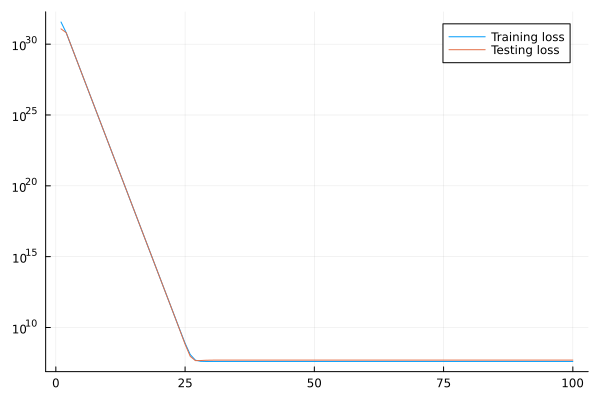

In [71]:
# part a

# general NN model which will take a train and test set along with a specified model, the number of iterations, and the step-size and return the losses at each iteration (as described in tutorial 2)
function NN_model(model, N, alpha, X_train, y_train, X_test, y_test, scheduler::Bool)
    
    # Empty array to track training and testing loss
    loss_train = Any[]
    loss_test = Any[]

    # Define optimizer
    opt = Flux.Descent(alpha)

    # Define loss function
    loss_fn(x, y) = Flux.mse(model(x), y)

    # training loop
    for i in 1:N

        Flux.train!(loss_fn, Flux.params(model), [(X_train, y_train)], opt)
        
        # scheduler defined in part c, if this is true and for every 20 iterations, lower alpha
        if scheduler && i % 20 == 0
            alpha = alpha * 0.9
            opt = Flux.Descent(alpha)
            
        end

        # forward pass to calculate loss
        push!(loss_train, loss_fn(X_train, y_train))
        push!(loss_test, loss_fn(X_test, y_test))    

    end
    
    return loss_train, loss_test
    
end

# model for part a
model_a = Chain(
            Flux.Dense(5, 12, Flux.relu),
            Flux.Dense(12, 3)
        )

# number of iterations
N_a = 100

# calls model
loss_train, loss_test = NN_model(model_a, N_a, alpha, X_train, y_train, X_test, y_test, false)

# plots training and testing losses from a
plot(range(1, N_a), [loss_train[1:N_a] loss_test[1:N_a]], label = ["Training loss" "Testing loss"], yaxis=:log)

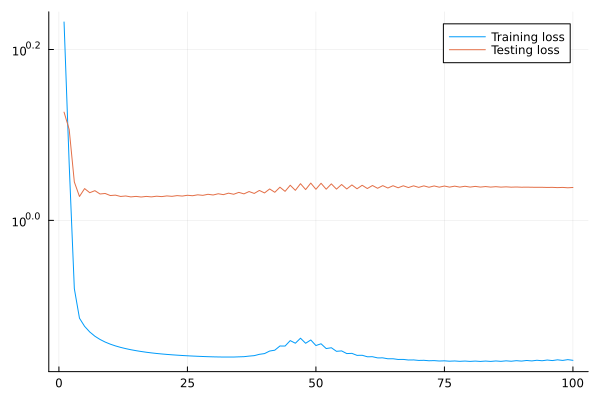

In [72]:
# part b

# initialization of means and std for X and y
x_means = Any[]
x_stds = Any[]
y_means = Any[]
y_stds = Any[]

# calculations for means and std of the features in x
for i in 1 : x_features
    push!(x_means, mean(X[i, :]))
    push!(x_stds, std(X[i, :]))
    
end

# calculations for means and std of the features in y
for i in 1 : y_len
    push!(y_means, mean(y[i, :]))
    push!(y_stds, std(y[i, :]))
    
end

# initialization of standardized X and y
X_stand = zeros(x_features, data_len)
y_stand = zeros(y_len, data_len)

# given formulas to calculate the standarization
for i in 1 : data_len
    X_stand[:, i] = (X[:, i] .- x_means) ./ x_stds
    y_stand[:, i] = (y[:, i] .- y_means) ./ y_stds
    
end

# model for part b
model_b = Chain(
            Flux.Dense(5, 12, Flux.relu),
            Flux.Dense(12, 3)
        )

# splits standarized data into train and test
X_stand_train = Matrix(X_stand[:, 1 : N_train])
X_stand_test = Matrix(X_stand[:, N_train + 1 : N_train + N_test])
y_stand_train = Matrix(y_stand[:, 1 : N_train])
y_stand_test = Matrix(y_stand[:, N_train + 1 : N_train + N_test])

# calls model
loss_train, loss_test = NN_model(model_b, N_a, alpha, X_stand_train, y_stand_train, X_stand_test, y_stand_test, false)

# plot for part b
plot(range(1, N_a), [loss_train[1:N_a] loss_test[1:N_a]], label = ["Training loss" "Testing loss"], yaxis=:log)

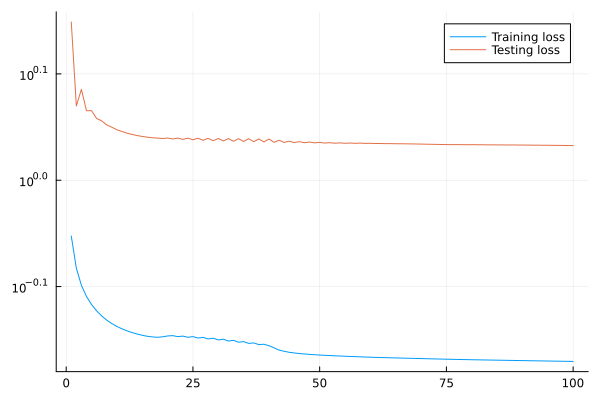

In [74]:
# part c

# model for part c
model_c = Chain(
            Flux.Dense(5, 12, Flux.relu),
            Flux.Dense(12, 3)
        )

# calls model
loss_train_c, loss_test_c = NN_model(model_c, N_a, alpha, X_stand_train, y_stand_train, X_stand_test, y_stand_test, true)

# plot for c
plot(range(1, N_a), [loss_train_c[1:N_a] loss_test_c[1:N_a]], label = ["Training loss" "Testing loss"], yaxis=:log)

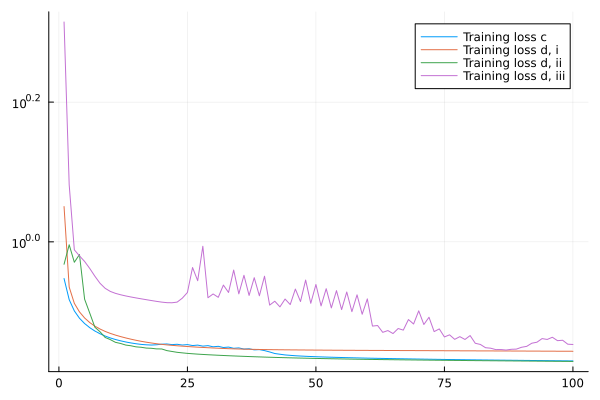

In [76]:
# part d

# we have 3 models as described in part d
model_di = Chain(
            Flux.Dense(5, 6, Flux.relu),
            Flux.Dense(6, 3)
        )
model_dii = Chain(
            Flux.Dense(5, 24, Flux.relu),
            Flux.Dense(24, 3)
        )
model_diii = Chain(
            Flux.Dense(5, 12, Flux.relu),
            Flux.Dense(12, 8, Flux.relu),
            Flux.Dense(8, 3)
        )

# calls model for each defined model above
loss_train_di, loss_test_di = NN_model(model_di, N_a, alpha, X_stand_train, y_stand_train, X_stand_test, y_stand_test, true)
loss_train_dii, loss_test_dii = NN_model(model_dii, N_a, alpha, X_stand_train, y_stand_train, X_stand_test, y_stand_test, true)
loss_train_diii, loss_test_diii = NN_model(model_diii, N_a, alpha, X_stand_train, y_stand_train, X_stand_test, y_stand_test, true)

# plots all 3 models' and model from part c's training losses on one plot
plot(range(1, N_a), [loss_train_c[1:N_a] loss_train_di[1:N_a] loss_train_dii[1:N_a] loss_train_diii[1:N_a] ], label = ["Training loss c" "Training loss d, i" "Training loss d, ii" "Training loss d, iii"], yaxis=:log)